# ESS563 – Exercise 1: Elastic Intuition, Fluids, and Anisotropy

**Assigned:** 2025-09-30  
**Estimated time:** ~3–5 hours  
**Submit:** Upload this notebook (as .ipynb) to Canvas with your name in the filename.

### Learning goals
- Practice **vibe coding**: build intuition-first code, sanity checks, and systematic debugging.
- Build **elasticity intuition** by writing small functions for $(\lambda, \mu, K, V_p, V_s, \rho)$.
- Explore **fluid effects**: dry vs. partially vs. fully saturated rocks (Gassmann/Wood) and sensitivities relevant to $\Delta v / v$ and **Vp/Vs tomography**.
- Introduce simple **anisotropy** (TI with Thomsen parameters) and see how it changes wave speeds and polarizations.
- Use **Helmholtz decomposition** on a synthetic 2-D displacement field to separate P and S content and illustrate **shear-wave splitting**.


## 0) Setup
> **Vibe-coding rule-of-thumb:** before each block, **predict** what the output should look like; after running, compare and write a one-line reflection. Use `assert` statements and tiny toy inputs to catch bugs early.


In [16]:
import numpy as np
import matplotlib.pyplot as plt

def predict(msg):
    print(f"[Prediction] {msg}")

## Part 1 — Elastic building blocks (dry frame)

Implement small, testable functions and **docstrings**.

We work with standard symbols:
- $\lambda, \mu$: Lamé parameters, $\mu$ is the shear modulus.
- $K$: bulk modulus, $\rho$: density.
- $V_p = \sqrt{(K + 4\mu/3)/\rho} = \sqrt{(\lambda + 2\mu)/\rho}$, $V_s = \sqrt{\mu/\rho}$.

**Tasks**
1. Write functions `vp_vs_from_lame(lmbda, mu, rho)` and `lame_from_k_mu(K, mu)`.
2. Write `random_sanity()` that builds random but **physically-sensible** triples $(K, \mu, \rho)$ and checks: $K>0, \mu>0, \rho>0, V_p>V_s>0$.
3. Make a **grid** of $(K, \mu)$ at fixed $\rho=2600$ kg/m³ and **contour-plot** $V_p$, $V_s$, and $V_p/V_s$ (three small panels or sequential figures). Add **bulleted** observations.


In [17]:
def vp_vs_from_lame(lmbda, mu, rho):
    """Return Vp, Vs from Lamé parameters and density."""
    assert np.all(mu > 0), "mu must be positive"
    assert np.all(rho > 0), "rho must be positive"
    Vp = np.sqrt((lmbda + 2.0*mu)/rho)
    Vs = np.sqrt(mu/rho)
    return Vp, Vs

def lame_from_k_mu(K, mu):
    """Return lambda from bulk and shear moduli."""
    assert np.all(K > 0) and np.all(mu > 0), "K, mu must be positive"
    lmbda = K - 2.0*mu/3.0
    return lmbda

def random_sanity(n=200, rho=2600.0, K_range=(1e9, 8e10), mu_range=(1e9, 6e10)):
    rng = np.random.default_rng(42)
    K = rng.uniform(*K_range, size=n)
    mu = rng.uniform(*mu_range, size=n)
    lam = lame_from_k_mu(K, mu)
    Vp, Vs = vp_vs_from_lame(lam, mu, rho)
    ok = np.all(Vp>Vs) and np.all(Vs>0) and np.all(Vp>0)
    return ok, (Vp.min(), Vp.max(), Vs.min(), Vs.max())

ok, spans = random_sanity()
print("sanity:", ok, "Vp/Vs spans:", spans)

sanity: True Vp/Vs spans: (np.float64(2044.6614461313545), np.float64(7551.970890732313), np.float64(814.734139607131), np.float64(4772.165334622744))


Add 3–5 bullet-point observations in the next markdown cell.


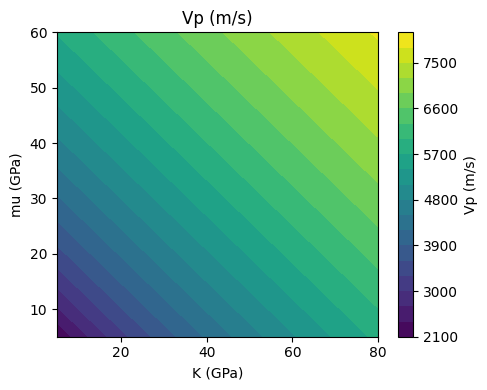

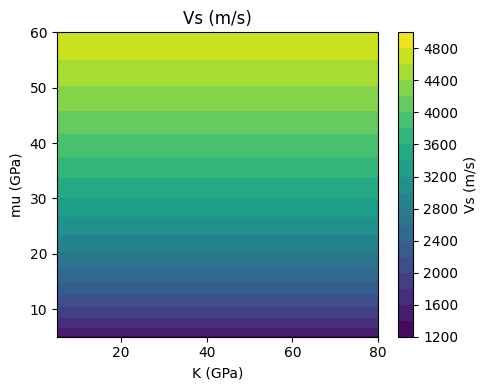

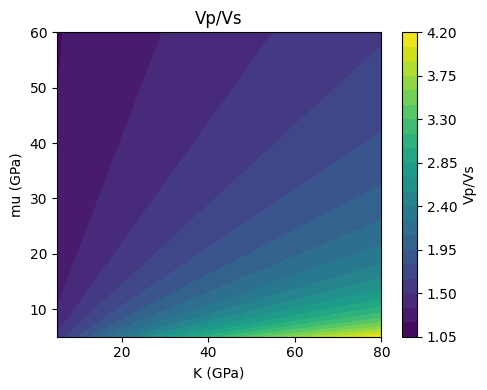

In [18]:
def plot_v_grid(rho=2600.0):
    K = np.linspace(5e9, 8e10, 120)
    mu = np.linspace(5e9, 6e10, 120)
    KK, MU = np.meshgrid(K, mu)
    lam = lame_from_k_mu(KK, MU)
    Vp, Vs = vp_vs_from_lame(lam, MU, rho)
    Zs = [Vp, Vs, Vp/Vs]
    titles = ["Vp (m/s)", "Vs (m/s)", "Vp/Vs"]
    for Z, t in zip(Zs, titles):
        plt.figure(figsize=(5,4))
        cs = plt.contourf(KK*1e-9, MU*1e-9, Z, levels=20)
        plt.colorbar(cs, label=t)
        plt.xlabel("K (GPa)")
        plt.ylabel("mu (GPa)")
        plt.title(t)
        plt.tight_layout()
    print("Add 3–5 bullet-point observations in the next markdown cell.")
plot_v_grid()

## Part 2 — Fluids & saturation (Wood + Gassmann)

Let the mineral be quartz (bulk $K_m \approx 37$ GPa, $\rho_m \approx 2650$ kg/m³). Porosity $\phi \in [0, 0.35]$.
- **Fluid mix** bulk with **Wood's law**: $1/K_f = \sum_i S_i / K_{f,i}$, with saturations $S_i$.
- Dry frame bulk $K_{\text{dry}}$ and shear $\mu_{\text{dry}}$: start with a simple empirical model (e.g., $K_{\text{dry}} = \alpha K_m (1-\phi)/(1+\beta \phi)$; choose $\alpha,\beta$ to keep values physical), or parameterize directly.
- **Gassmann** saturated bulk: 
$$K_{\text{sat}} = K_{\text{dry}} + \frac{(1 - K_{\text{dry}}/K_m)^2}{\phi/K_f + (1-\phi)/K_m - K_{\text{dry}}/K_m^2}$$
Shear $\mu$ unchanged by fluids: $\mu_{\text{sat}} = \mu_{\text{dry}}$.

**Tasks**
1. Implement `wood_bulk(fluid_bulk, saturations)` and `gassmann(Kdry, mudry, Km, phi, Kf)`.
2. Sweep $\phi$ and $S_{\text{water}}$ (with air present) and plot **$\Delta v/v$** for $V_p$ and $V_s$ relative to the dry frame. Summarize trends relevant to **Vp/Vs tomography**.
3. Pick two contrasting fluid cases (dry vs. fully water‑saturated) and plot **sensitivity kernels**: partial derivatives $\partial V_p/\partial \phi$, $\partial V_p/\partial K_f$ (finite differences are fine).

Discuss: Why is Vs far less sensitive to fluids than Vp? Implications for Vp/Vs tomography.


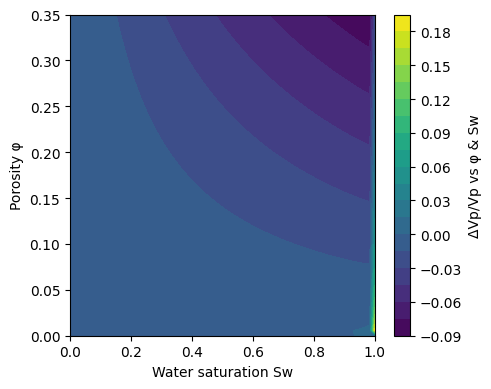

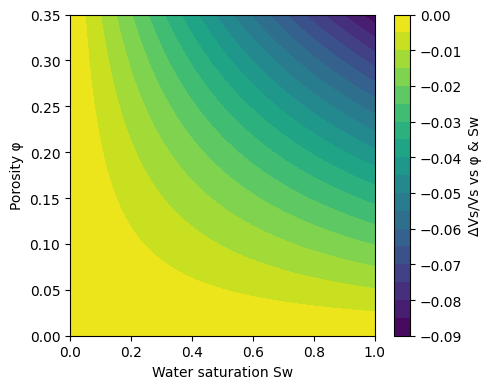

In [19]:
def wood_bulk(K_list, S_list):
    K_list = np.asarray(K_list, float)
    S_list = np.asarray(S_list, float)
    assert np.isclose(S_list.sum(), 1.0), "Saturations must sum to 1"
    return 1.0 / np.sum(S_list / K_list)

def gassmann(Kdry, mudry, Km, phi, Kf):
    num = (1 - Kdry/Km)**2
    den = phi/Kf + (1-phi)/Km - Kdry/(Km*Km)
    Ksat = Kdry + (num/den)
    musat = mudry
    return Ksat, musat

# Example sweep
Km = 37e9; rho_m = 2650.0
phi = np.linspace(0.0, 0.35, 60)
S_w = np.linspace(0.0, 1.0, 61)

# Simple dry frame parameterization (tunable but positive definite)
def dry_frame(phi, Km=Km):
    Kdry = 0.5*Km*(1-phi)/(1+0.5*phi)
    mudry = 0.4*Km*(1-phi)
    return Kdry, mudry

K_air, K_water = 1.4e5, 2.2e9  # Pa
rho_air, rho_water = 1.2, 1000.0

Vp_dv = np.zeros((phi.size, S_w.size))
Vs_dv = np.zeros_like(Vp_dv)

rho_bulk = np.zeros_like(Vp_dv)

for i,p in enumerate(phi):
    Kdry, mudry = dry_frame(p)
    for j,Sw in enumerate(S_w):
        Kf = wood_bulk([K_air, K_water],[1-Sw, Sw])
        Ksat, musat = gassmann(Kdry, mudry, Km, p, Kf)
        # density: volumetric mix of solid and fluids (simple)
        rhof = (1-Sw)*rho_air + Sw*rho_water
        rho = (1-p)*rho_m + p*rhof
        lam = Ksat - 2*musat/3
        Vp = np.sqrt((lam + 2*musat)/rho)
        Vs = np.sqrt(musat/rho)
        # Dry reference (Sw=0)
        Kf0 = wood_bulk([K_air, K_water],[1.0, 0.0])
        Ksat0, musat0 = gassmann(*dry_frame(p), Km, p, Kf0)
        rho0 = (1-p)*rho_m + p*((1.0)*rho_air + 0.0*rho_water)
        lam0 = Ksat0 - 2*musat0/3
        Vp0 = np.sqrt((lam0 + 2*musat0)/rho0)
        Vs0 = np.sqrt(musat0/rho0)
        Vp_dv[i,j] = (Vp - Vp0)/Vp0
        Vs_dv[i,j] = (Vs - Vs0)/Vs0
        rho_bulk[i,j] = rho

# Plot dv/v maps
for Z, title in [(Vp_dv, "ΔVp/Vp vs φ & Sw"), (Vs_dv, "ΔVs/Vs vs φ & Sw")]:
    plt.figure(figsize=(5,4))
    cs = plt.contourf(S_w, phi, Z, levels=21)
    plt.colorbar(cs, label=title)
    plt.xlabel("Water saturation Sw")
    plt.ylabel("Porosity φ")
    plt.tight_layout()
print("Discuss: Why is Vs far less sensitive to fluids than Vp? Implications for Vp/Vs tomography.")

## Part 3 — Simple anisotropy (TI with Thomsen ε, δ, γ)

For a VTI medium with vertical symmetry axis and isotropic density $\rho$:
- $V_{P0} = \sqrt{(\lambda + 2\mu)/\rho}$, $V_{S0} = \sqrt{\mu/\rho}$.
- Phase $V_P(\theta) \approx V_{P0}\left[1 + \delta \sin^2\theta \cos^2\theta + \epsilon \sin^4\theta\right]$ (weak anisotropy).
- $V_{S,\text{fast/slow}}(\theta)$ depend on $\gamma$ and polarization; illustrate **shear splitting** via a simple delay $\Delta t = L(V_{S,\text{fast}}^{-1}-V_{S,\text{slow}}^{-1})$.

**Tasks**
1. Implement `vti_vp(theta, VP0, eps, delt)` and a toy `vti_vs_fast_slow(theta, VS0, gam)` using a weak‑anisotropy approximation.
2. Plot polar diagrams for VP and the two VS branches for a few $(\epsilon, \delta, \gamma)$ choices.
3. For a path length $L=20$ km, compute splitting delay vs. back‑azimuth and make a rose plot.

Example splitting delay at θ=90°: 289.20 ms


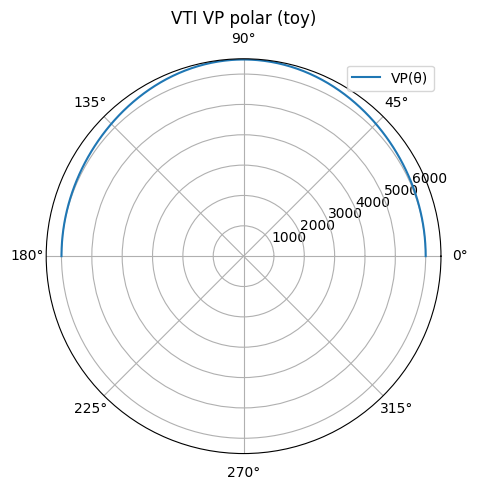

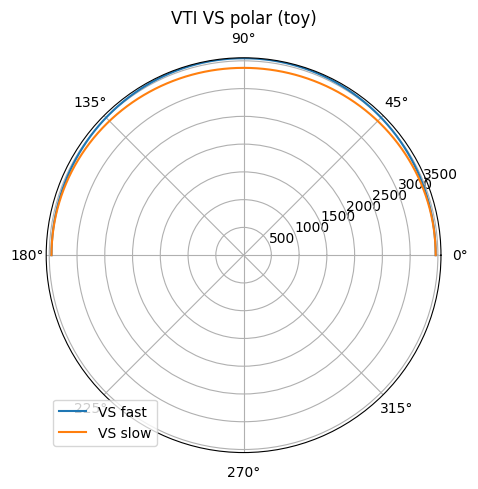

In [20]:
def vti_vp(theta, VP0, eps, delt):
    s = np.sin(theta); c = np.cos(theta)
    return VP0*(1 + delt*(s**2)*(c**2) + eps*(s**4))

def vti_vs_fast_slow(theta, VS0, gam):
    # Toy model: transverse isotropy split proportional to gamma*sin^2(theta)
    # returns VSfast, VSSlow
    s = np.sin(theta)
    split = gam*(s**2)
    VSfast = VS0*(1 + 0.5*split)
    VSlow  = VS0*(1 - 0.5*split)
    return VSfast, VSlow

VP0, VS0 = 6000.0, 3460.0
eps, delt, gam = 0.08, 0.03, 0.05
th = np.linspace(0, np.pi, 361)
VP = vti_vp(th, VP0, eps, delt)
VSf, VSs = vti_vs_fast_slow(th, VS0, gam)

plt.figure(figsize=(5,5))
plt.polar(th, VP, label="VP(θ)")
plt.title("VTI VP polar (toy)")
plt.legend(); plt.tight_layout()

plt.figure(figsize=(5,5))
plt.polar(th, VSf, label="VS fast")
plt.polar(th, VSs, label="VS slow")
plt.title("VTI VS polar (toy)")
plt.legend(); plt.tight_layout()

# Splitting delay vs back-azimuth for horizontal incidence (θ=π/2)
theta = np.pi/2
VSf0, VSs0 = vti_vs_fast_slow(theta, VS0, gam)
L = 20e3
dt = L*(1/VSs0 - 1/VSf0)
print(f"Example splitting delay at θ=90°: {dt*1000:.2f} ms")

## Part 4 — Helmholtz decomposition & P/S separation (synthetic)

Create a synthetic 2‑D displacement field **u(x,y)** that is a sum of a (quasi‑)P component and an (quasi‑)S component. Use finite differences to compute:
- scalar potential $\phi$ from divergence, and vector potential $\mathbf{A}$ from the out‑of‑plane curl (2‑D).
- Show that applying the decomposition separates the two energy types.
- Optionally, simulate anisotropy by rotating the S polarization direction and show the induced **apparent splitting** in the recovered S field.

**Tasks**
1. Make a 2‑D grid and synthesize a plane‑wave P and S packet with different wavenumbers.
2. Compute divergence and curl and visualize maps of $|\nabla \cdot \mathbf{u}|$ and $|\nabla \times \mathbf{u}|$.
3. Discuss how this relates to separating P/S in real wavefield imaging.

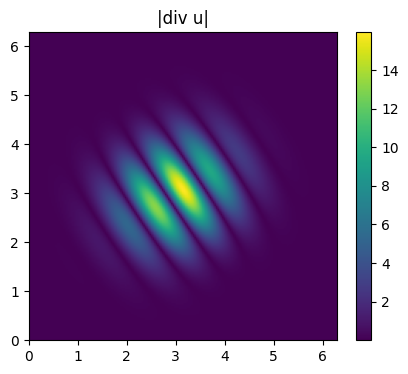

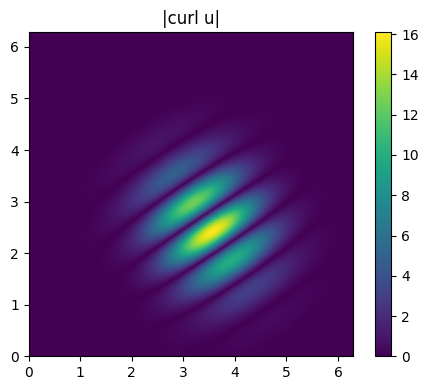

In [21]:
# 2-D synthetic displacement field and Helmholtz-like separation
nx, ny = 200, 200
x = np.linspace(0, 2*np.pi, nx)
y = np.linspace(0, 2*np.pi, ny)
XX, YY = np.meshgrid(x, y, indexing='ij')

# P-like: gradient of scalar potential
phi = np.exp(-((XX-3)**2 + (YY-3)**2)/1.2) * np.cos(3*XX + 2*YY)
ux_p = np.gradient(phi, x, axis=0)
uy_p = np.gradient(phi, y, axis=1)

# S-like: divergence-free using stream function psi
psi = np.exp(-((XX-3.5)**2 + (YY-2.5)**2)/1.2) * np.cos(2*XX - 3*YY)
ux_s =  np.gradient(psi, y, axis=1)   # +dpsi/dy
uy_s = -np.gradient(psi, x, axis=0)   # -dpsi/dx

ux = ux_p + ux_s
uy = uy_p + uy_s

# Finite-difference div and scalar curl (out of plane)
dux_dx = np.gradient(ux, x, axis=0)
duy_dy = np.gradient(uy, y, axis=1)
div_u = dux_dx + duy_dy

duy_dx = np.gradient(uy, x, axis=0)
dux_dy = np.gradient(ux, y, axis=1)
curl_z = duy_dx - dux_dy

plt.figure(figsize=(5,4)); plt.imshow(np.abs(div_u).T, origin='lower', extent=(x.min(), x.max(), y.min(), y.max())); plt.colorbar(); plt.title("|div u|")
plt.figure(figsize=(5,4)); plt.imshow(np.abs(curl_z).T, origin='lower', extent=(x.min(), x.max(), y.min(), y.max())); plt.colorbar(); plt.title("|curl u|")
plt.tight_layout()

# Seismic Velocities in Partially Saturated Media

This add-on notebook extends Exercise 1 with a derivation and implementation of shear-wave velocity $V_s$
as a function of saturation $S_w$, starting from **Hertz–Mindlin** contact theory and including
**static** and **dynamic** capillary effects in the effective confining pressure. Use this as **Part 6** and plug into your hydrology from Part 2.

**References to the provided supplement:** Equations (S3)–(S7) and the role of dynamic capillarity
in $P_e$ (hysteresis), plus Fig. S7 showing wetting–drying loops.

## Theory recap 
- $V_s = \sqrt{\mu_{\mathrm{eff}}/\rho}$   
- $\rho = (1-\phi)\rho_s + \phi[S_w\rho_w + (1-S_w)\rho_a]$   
- $\nu = \frac{3K_s-2\mu_s}{2(3K_s+\mu_s)}$   
- $P_e = \sigma_{ov} - p_a(1-S_{we}) - p_w S_{we} - \tau(S_w)\frac{dS_w}{dt}$   
  with $S_{we}=\frac{S_w-S_{wr}}{1-S_{wr}}\in[0,1]$.  
- $\mu_{\mathrm{eff}} = \left[\frac{2+3f-(1+3f)\nu}{5(2-\nu)}\right]\left[\frac{3N^2(1-\phi)^2}{2\pi^2(1-\nu)^2}\mu_s^2 P_e\right]^{1/3}$ .

We approximate the **dynamic coefficient** $\tau(S_w)$ with larger values during drying
and smaller (decaying with $S_w$) during wetting to reproduce hysteresis.

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# --- Constants & defaults (SI) ---
g = 9.80665
rho_w = 1000.0   # water
rho_a = 1.2      # air
rho_s = 2650.0   # quartz-like solid
Ks   = 37e9      # bulk modulus of grains (quartz)
mu_s = 44e9      # shear modulus of grains (quartz->nu~0.08)
phi_default = 0.35
Swr_sand, Swr_clay = 0.15, 0.25   # residual saturations (supplement)
N_sand, N_clay = 6, 8             # coordination number (HM)


In [23]:
def poisson_from_K_mu(Ks, mu_s):
    return (3*Ks - 2*mu_s) / (2*(3*Ks + mu_s))

def effective_density(Sw, phi, rho_s=rho_s, rho_w=rho_w, rho_a=rho_a):
    return (1-phi)*rho_s + phi*(Sw*rho_w + (1-Sw)*rho_a)

def effective_saturation(Sw, Swr):
    Swe = (Sw - Swr) / max(1e-9, (1 - Swr))
    return np.clip(Swe, 0.0, 1.0)

def overburden_pressure(z=1.0, rho_bulk=1800.0):
    return rho_bulk * g * z

def dynamic_tau(Sw, mode="auto"):
    if mode == "dry":
        return 5e5*np.ones_like(Sw)         # Pa per (dSw/dt) – larger during drying
    if mode == "wet":
        return 0.5e5*np.exp(-9.0*Sw)        # Pa per (dSw/dt) – decays with Sw during wetting
    return None

def effective_pressure(Sw, dSw_dt, phi, z=1.0, Swr=0.15, rho_bulk=1800.0, mode="auto"):
    Swe = effective_saturation(Sw, Swr)
    p_air = rho_a * g * z
    p_wat = rho_w * g * z
    sigma_ov = overburden_pressure(z=z, rho_bulk=rho_bulk)
    if mode == "auto":
        tau = np.where(dSw_dt>=0.0, dynamic_tau(Sw, "wet"), dynamic_tau(Sw, "dry"))
    else:
        tau = dynamic_tau(Sw, mode)
    Pe = sigma_ov - p_air*(1-Swe) - p_wat*Swe - tau*dSw_dt
    return np.maximum(Pe, 1.0)

def mu_eff_HM(Pe, phi, N=6, f=0.1, Ks=Ks, mu_s=mu_s):
    nu = poisson_from_K_mu(Ks, mu_s)
    A = (2+3*f-(1+3*f)*nu)/(5*(2-nu))
    B = (3*(N**2)*((1-phi)**2))/(2*(np.pi**2)*((1-nu)**2)) * (mu_s**2) * Pe
    return A * (B**(1/3.0))

def Vs_from_Sw(Sw, t, phi=phi_default, Swr=0.15, z=1.0, N=6, f=0.1, rho_bulk=1800.0):
    Sw = np.asarray(Sw, float); t = np.asarray(t, float)
    dSw_dt = np.gradient(Sw, t) if t.size>1 else np.zeros_like(Sw)
    Pe = effective_pressure(Sw, dSw_dt, phi, z=z, Swr=Swr, rho_bulk=rho_bulk, mode="auto")
    mu_eff = mu_eff_HM(Pe, phi, N=N, f=f)
    rho_eff = effective_density(Sw, phi)
    Vs = np.sqrt(np.maximum(mu_eff, 1.0)/rho_eff)
    return Vs, mu_eff, rho_eff, Pe


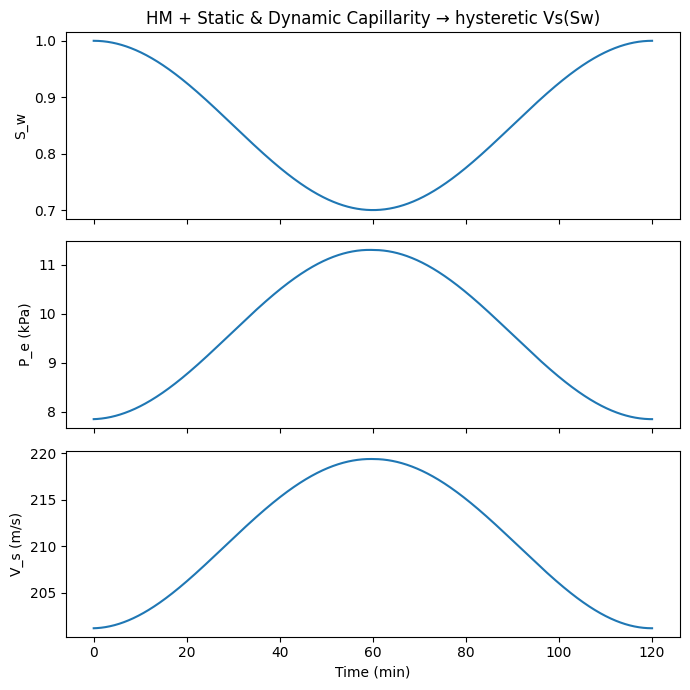

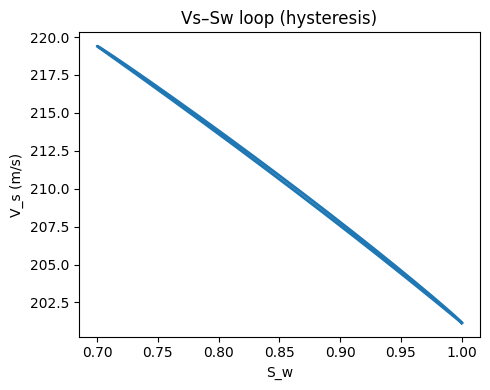

In [24]:
# --- Demo: Wetting -> Drying hysteresis in Vs(Sw) ---
T = 120*60.0  # total duration (s)
t = np.linspace(0, T, 1201)
Sw_mid = 0.85; amp = 0.15
Sw = Sw_mid + amp*np.cos(2*np.pi*t/T)   # wet->dry loop
Sw = np.clip(Sw, 0.5, 1.0)

phi = 0.35; Swr = 0.15; z = 1.0
Vs, mu_eff, rho_eff, Pe = Vs_from_Sw(Sw, t, phi=phi, Swr=Swr, z=z, N=6, f=0.15)

fig, axs = plt.subplots(3,1, figsize=(7,7), sharex=True)
axs[0].plot(t/60, Sw); axs[0].set_ylabel("S_w")
axs[1].plot(t/60, Pe*1e-3); axs[1].set_ylabel("P_e (kPa)")
axs[2].plot(t/60, Vs); axs[2].set_ylabel("V_s (m/s)"); axs[2].set_xlabel("Time (min)")
axs[0].set_title("HM + Static & Dynamic Capillarity → hysteretic Vs(Sw)")
plt.tight_layout()

plt.figure(figsize=(5,4))
plt.plot(Sw, Vs, lw=2)
plt.xlabel("S_w"); plt.ylabel("V_s (m/s)"); plt.title("Vs–Sw loop (hysteresis)")
plt.tight_layout()


### Connect to Part 2 hydrology
Replace the synthetic $S_w(t)$ with your modeled $S_w(t)$ from Part 2 (Wood + Gassmann and ET/drainage):
```python
Vs, mu_eff, rho_eff, Pe = Vs_from_Sw(Sw_model, t_model, phi=phi_value, Swr=Swr_sand, z=depth_m, N=N_sand, f=0.1)
```
Compare resulting $\Delta v/v$ with interferometric estimates. The dynamic term $\tau(S_w)\partial S_w/\partial t$ is what produces the **fast rebounds during drying** and sharper **drops during wetting**, consistent with the supplement's Fig. S7.

## Non-Linear Elasticity Framework for Saturated Media

## Part A — Pore-Pressure–Only Forcing (No External Load)

Assume **no change in total stress** $\Delta\sigma=0$. Effective mean stress changes follow
$$\Delta\sigma' = \Delta\sigma - \alpha\,\Delta p = -\,\alpha\,\Delta p.$$

For small strains in isotropic elasticity, volumetric strain is
$$\varepsilon_v = \frac{\Delta\sigma'_m}{K} = -\,\frac{\alpha}{K}\,\Delta p.$$

With the nonlinear elasticity link $\Delta v/v = \beta\,\varepsilon_v$, we obtain
$$\boxed{\frac{\Delta v}{v} = -\,\frac{\beta\,\alpha}{K}\,\Delta p}$$

If pore pressure is hydrostatic and linked to head change $\Delta h$ at the sensor depth,
$$\Delta p = \rho_w g\,\Delta h \quad\Rightarrow\quad
\boxed{\frac{\Delta v}{v} = -\,\frac{\beta\,\alpha\,\rho_w g}{K}\,\Delta h}$$

**Sign note.** If your convention takes compression as **positive** strain, then a rise in head (increasing $p$) reduces effective stress, leading to **dilatation** (negative compression), so the sign of $\Delta v/v$ depends on your chosen $\beta$ sign. Many near-surface observations are consistent with $\beta<0$ (velocity softens with compression).

## Part B — Surface-Load–Only Forcing (No Pore Pressure Change)

Set $\Delta p = 0$ but apply a surface load from water column changes: $\Delta\sigma_m = \rho_w g\,\Delta h$.
Then
$$\varepsilon_v = \frac{\rho_w g}{K}\,\Delta h
\quad\Rightarrow\quad
\boxed{\frac{\Delta v}{v} = \beta\,\frac{\rho_w g}{K}\,\Delta h}$$

This term is **in phase** with $h$ (no diffusion), whereas the pore-pressure pathway (Part C) can **lag**.

## Part C — Combined Forcing with Diffusive Pore Pressure (Phase & Amplitude)

Let surface head be $h_s(t)$. Pore pressure at depth evolves toward hydrostatic equilibrium with a time constant $\tau$, giving a **first-order low-pass** response:
$$\Delta p(t) = \rho_w g\,H(t), \qquad \tau\,\dot H + H = h_s(t).$$

In the frequency domain (harmonic forcing of angular frequency $\omega$), the transfer function is
$$\frac{H}{h_s} = \frac{1}{1+i\omega\tau}.$$

Total volumetric strain combines the **surface load** and the **effective-stress relief** from pore pressure:
$$\varepsilon_v(t) = \frac{1}{K}\big(\rho_w g\,h_s(t) - \alpha\,\Delta p(t)\big).$$

Hence,
$$\frac{\Delta v}{v}(t) = \beta\,\varepsilon_v(t),$$

and for harmonic forcing the complex gain from $h_s$ to $\Delta v/v$ is
$$\boxed{G(\omega) = \frac{\Delta v/v}{\,\Delta h_s\,} = \frac{\beta\,\rho_w g}{K}\left(1 - \frac{\alpha}{1+i\omega\tau}\right)}$$

with amplitude $|G|$ and phase $\phi=\arg(G)$. At **DC** ($\omega\to 0$):
$$G(0) = \frac{\beta\,\rho_w g}{K}(1-\alpha).$$

Thus low-frequency slopes constrain the combination $\beta(1-\alpha)/K$, not each parameter individually.

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def dvv_from_dp(dp, beta, alpha, K):
    """Δv/v from pore pressure change dp (Pa)."""
    return -beta * alpha * dp / K

def dvv_from_dh_surface(dh, beta, K, rho_w=1000.0, g=9.80665):
    """Δv/v from surface load only (water head dh in m)."""
    return beta * (rho_w * g / K) * dh

def gain_G(omega, beta, alpha, K, tau, rho_w=1000.0, g=9.80665):
    """Complex gain G(ω) = (Δv/v)/(Δh)."""
    return (beta * rho_w * g / K) * (1.0 - alpha / (1.0 + 1j * omega * tau))

def amp_phase(G):
    """Return amplitude and phase (radians) of complex G."""
    return np.abs(G), np.angle(G)

def simulate_time_series(t, h, beta, alpha, K, tau, rho_w=1000.0, g=9.80665):
    """Simulate Δv/v(t) given head h(t) using first-order LP for pore pressure (τ)."""
    dt = np.median(np.diff(t))
    H = np.zeros_like(h)
    # Exponential filter: τ dH/dt + H = h  -> H[n] = H[n-1] + (dt/τ)*(h[n-1]-H[n-1])
    a = dt / tau if tau > 0 else 1.0
    for n in range(1, len(h)):
        H[n] = H[n-1] + a * (h[n-1] - H[n-1])
    dp = rho_w * g * H
    # total strain: (surface load) - α*(pore pressure) divided by K
    eps = (rho_w * g * h - alpha * dp) / K
    dvv = beta * eps
    return dvv, H, dp, eps


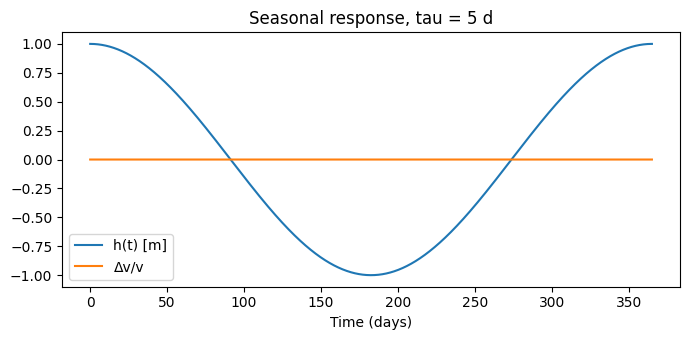

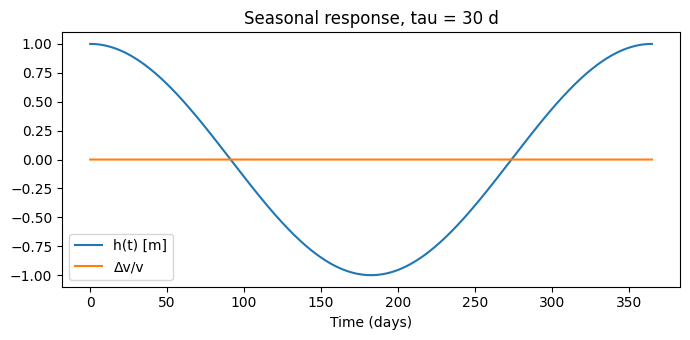

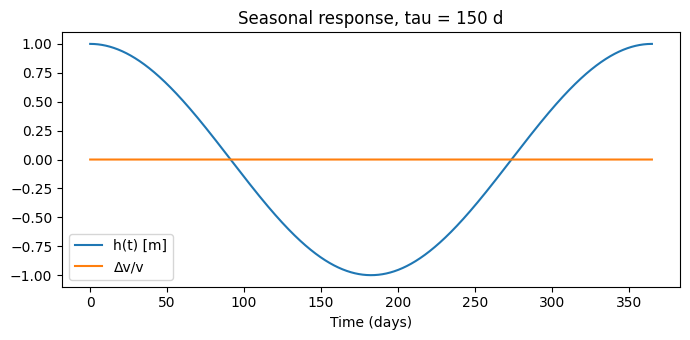

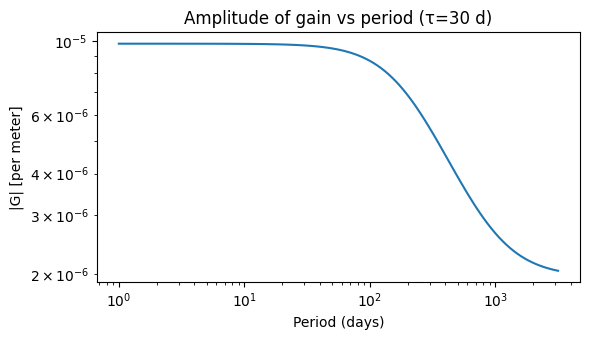

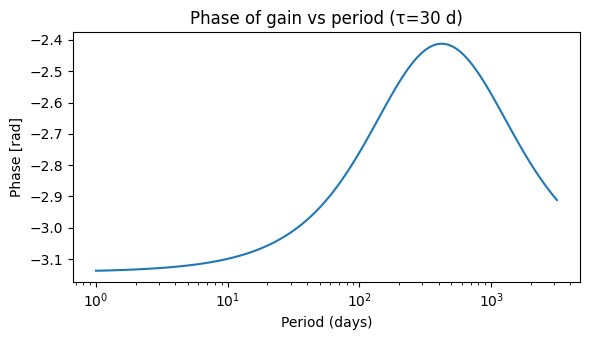

In [26]:
# Demo: seasonal head (A=1 m), T=1 year, compare τ
A = 1.0
T_days = 365.0
T = T_days * 24 * 3600
omega = 2 * np.pi / T
t = np.linspace(0, T, 2000)
h = A * np.cos(omega * t)

# Parameters
K = 10e9       # Pa
alpha = 0.8
beta = -10.0   # dimensionless (ppm per microstrain ≈ -10 -> -10e-6 dv/v per 1e-6 strain)
taus_days = [5, 30, 150]
taus = [d * 24 * 3600 for d in taus_days]

for tau in taus:
    dvv, H, dp, eps = simulate_time_series(t, h, beta, alpha, K, tau)
    # Plot dv/v vs time
    plt.figure(figsize=(7,3.5))
    plt.plot(t/(24*3600), h, label='h(t) [m]')
    plt.plot(t/(24*3600), dvv, label='Δv/v')
    plt.xlabel('Time (days)'); plt.title(f'Seasonal response, tau = {tau/(24*3600):.0f} d')
    plt.legend(); plt.tight_layout()

# Frequency response: amplitude & phase vs period
periods_days = np.logspace(0, 3.5, 120)  # ~1 d to ~3000 d
omegas = 2*np.pi / (periods_days * 24*3600)
Gvals = [gain_G(w, beta, alpha, K, taus[1]) for w in omegas]  # use middle tau for example
amps = np.abs(Gvals)
phs = np.angle(Gvals)

plt.figure(figsize=(6,3.5))
plt.loglog(periods_days, amps)
plt.xlabel('Period (days)'); plt.ylabel('|G| [per meter]'); plt.title('Amplitude of gain vs period (τ=30 d)')
plt.tight_layout()

plt.figure(figsize=(6,3.5))
plt.semilogx(periods_days, phs)
plt.xlabel('Period (days)'); plt.ylabel('Phase [rad]'); plt.title('Phase of gain vs period (τ=30 d)')
plt.tight_layout()


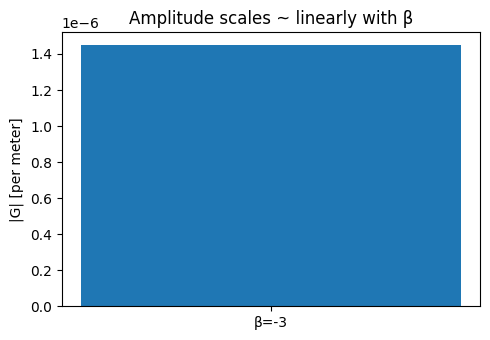

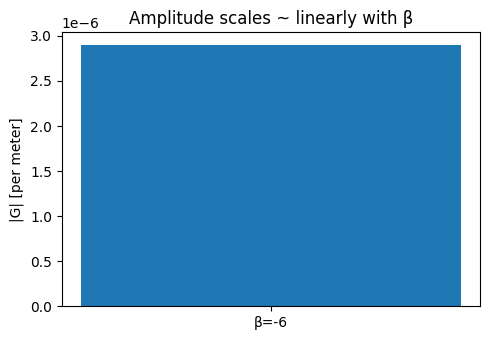

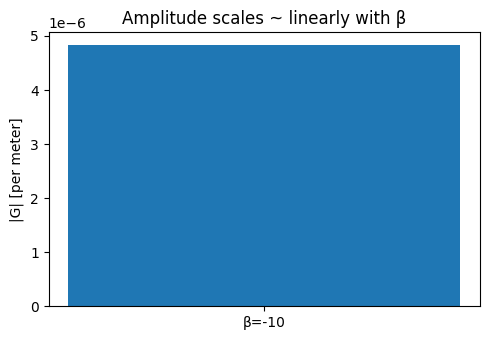

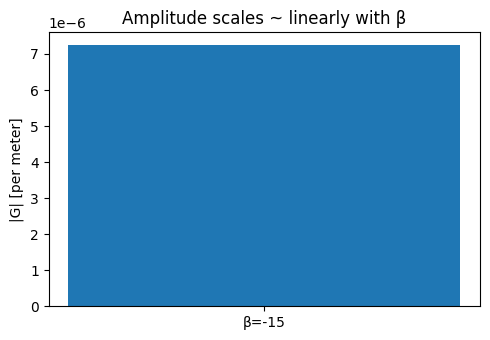

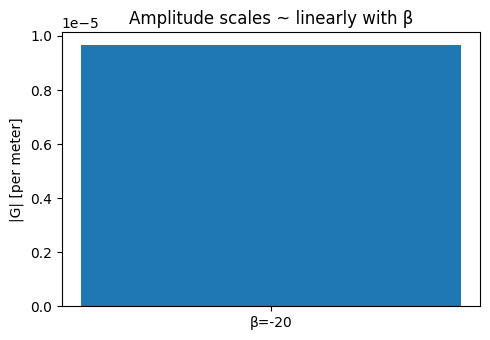

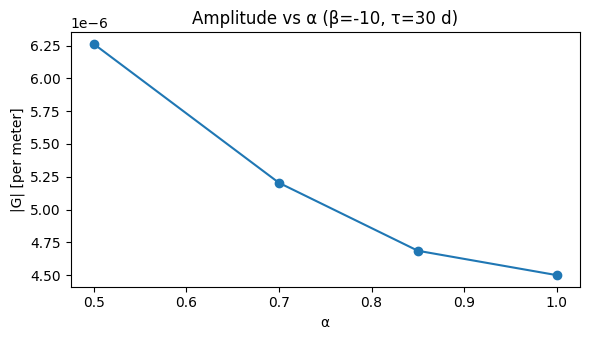

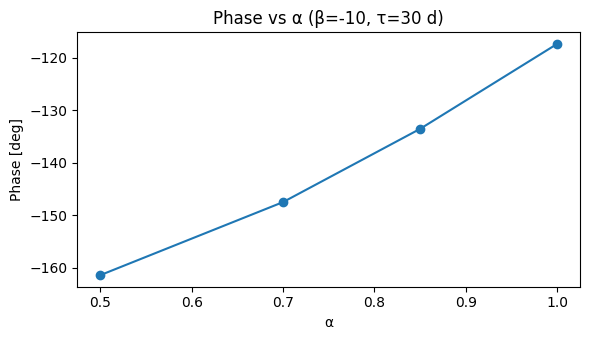

In [27]:
# Sweep β: amplitude scaling, weak phase effect
K = 10e9; alpha = 0.8; tau = 30*24*3600
betas = [-3, -6, -10, -15, -20]
period = 365*24*3600
w = 2*np.pi/period
for b in betas:
    G = gain_G(w, b, alpha, K, tau)
    amp, ph = amp_phase(G)
    plt.figure(figsize=(5,3.5))
    plt.bar([0], [amp])
    plt.xticks([0], [f'β={b}'])
    plt.ylabel('|G| [per meter]'); plt.title('Amplitude scales ~ linearly with β')
    plt.tight_layout()

# Sweep α: amplitude & phase tradeoff at fixed β
beta = -10; alphas = [0.5, 0.7, 0.85, 1.0]; w = 2*np.pi/(365*24*3600)
amps = []; phs = []
for a in alphas:
    G = gain_G(w, beta, a, K, tau)
    A, P = amp_phase(G); amps.append(A); phs.append(P)

plt.figure(figsize=(6,3.5))
plt.plot(alphas, amps, marker='o')
plt.xlabel('α'); plt.ylabel('|G| [per meter]'); plt.title('Amplitude vs α (β=-10, τ=30 d)')
plt.tight_layout()

plt.figure(figsize=(6,3.5))
plt.plot(alphas, np.array(phs)*(180/np.pi), marker='o')
plt.xlabel('α'); plt.ylabel('Phase [deg]'); plt.title('Phase vs α (β=-10, τ=30 d)')
plt.tight_layout()


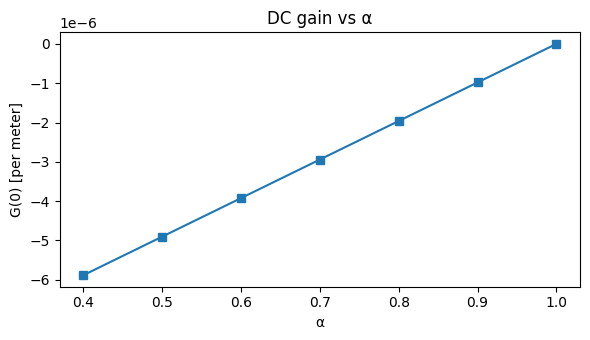

In [28]:
# DC gain check: G(0) = β ρ_w g / K * (1 - α)
rho_w = 1000.0; g = 9.80665
beta = -10; K = 10e9
alphas = np.linspace(0.4, 1.0, 7)
G0 = beta * rho_w * g / K * (1 - alphas)

plt.figure(figsize=(6,3.5))
plt.plot(alphas, G0, marker='s')
plt.xlabel('α'); plt.ylabel('G(0) [per meter]'); plt.title('DC gain vs α')
plt.tight_layout()



## What to submit
- Completed code above with your **inline predictions and reflections**.
- 3–8 bullet points of takeaways on: (i) fluid effects on Vp, Vs, and Vp/Vs; (ii) anisotropy and shear splitting; (iii) how Helmholtz decomposition helps separate P/S energy.
- 1 figure (your favorite) with a 2–3 sentence caption.

**Grading (20 pts)**
- [6] Correctness & physical sanity (tests, asserts, positive definiteness).
- [6] Insightful plots & commentary (clear, labeled, concise).
- [5] Vibe-coding practice (predictions & reflections present in each section).
- [3] Clean structure & readability (docstrings, small functions, no dead code).
